In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
options = 'results=8000&timezone=America%2FSao_Paulo'
data = requests.get('https://api.thingspeak.com/channels/657211/feeds.json?'+options).content
feeds = json.loads(data)['feeds']
display(feeds[0])
display(feeds[-1])

{'created_at': '2019-07-16T16:01:41-03:00',
 'entry_id': 27902,
 'field1': None,
 'field2': None,
 'field3': '29.10',
 'field4': '50.00\r\n\r\n'}

{'created_at': '2019-07-23T14:34:34-03:00',
 'entry_id': 35901,
 'field1': None,
 'field2': None,
 'field3': '28.80',
 'field4': '63.00\r\n\r\n'}

In [3]:
df = pd.DataFrame.from_dict(feeds)
fields = [x for x in df.columns if x.startswith('field')]
for field in fields:
    df[field] = df[field].str.replace('\r\n','').astype(float)
df['created_at'] = pd.to_datetime(df['created_at'])

In [4]:
df.tail()

,created_at,entry_id,field1,field2,field3,field4
7995,2019-07-23 17:30:33,35897,NaN,NaN,29.1,63.0
7996,2019-07-23 17:31:21,35898,27.7,67.0,NaN,NaN
7997,2019-07-23 17:32:33,35899,NaN,NaN,29.2,63.0
7998,2019-07-23 17:33:21,35900,27.8,67.0,NaN,NaN
7999,2019-07-23 17:34:34,35901,NaN,NaN,28.8,63.0


In [5]:
df2 =  df.set_index('created_at').resample("5T").mean()[fields]

In [6]:
df_old = pd.read_pickle('data.pickle')
df_old = df_old.append(df2)
df_old = df_old.drop_duplicates().resample("5T").mean()[fields]

In [7]:
df_old.tail()

,field1,field2,field3,field4
created_at,,,,
2019-07-23 17:10:00,27.750,67.0,29.233333,61.666667
2019-07-23 17:15:00,27.800,67.0,29.250000,62.000000
2019-07-23 17:20:00,27.800,67.0,29.233333,61.666667
2019-07-23 17:25:00,27.800,67.0,29.300000,61.500000
2019-07-23 17:30:00,27.725,67.0,29.079167,63.000000


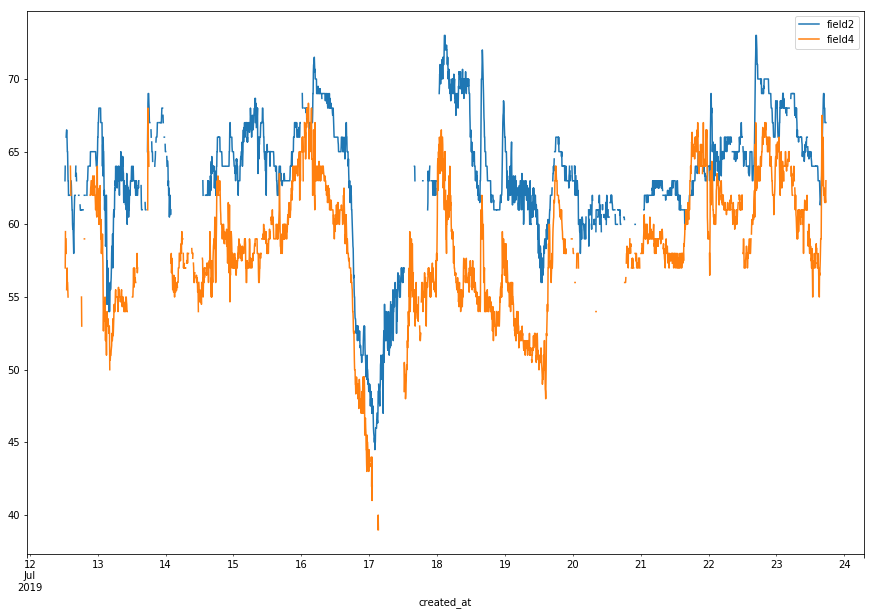

In [8]:
df_old[['field2','field4']].plot(figsize=(15,10),)

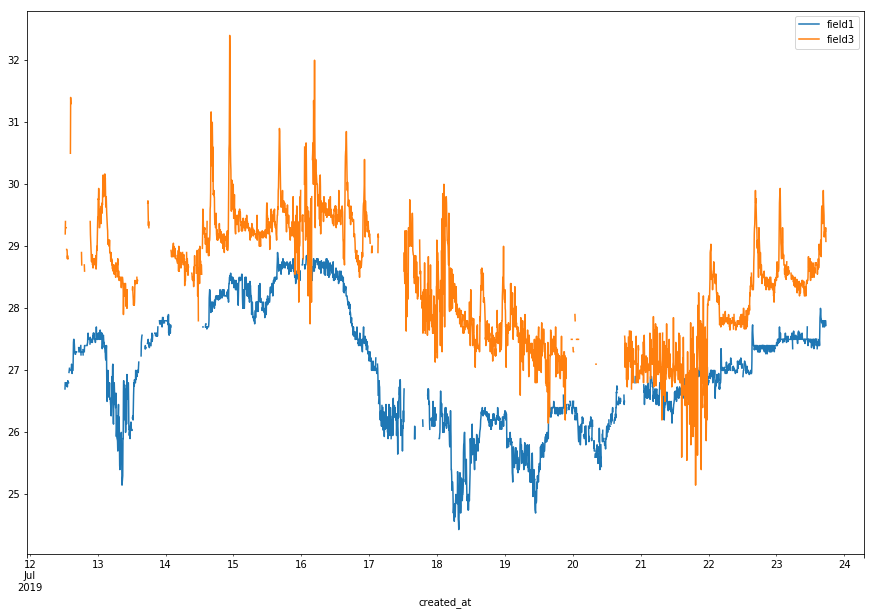

In [9]:
df_old[['field1','field3']].plot(figsize=(15,10))

In [10]:
df_old.to_pickle('data.pickle')

In [11]:
dfx = df_old.reset_index()
#dfx.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
dfx['date2'] = dfx['created_at'].dt.hour + dfx['created_at'].dt.minute/60 + dfx['created_at'].dt.second/3600
dfx.tail()

,created_at,field1,field2,field3,field4,date2
3225,2019-07-23 17:10:00,27.750,67.0,29.233333,61.666667,17.166667
3226,2019-07-23 17:15:00,27.800,67.0,29.250000,62.000000,17.250000
3227,2019-07-23 17:20:00,27.800,67.0,29.233333,61.666667,17.333333
3228,2019-07-23 17:25:00,27.800,67.0,29.300000,61.500000,17.416667
3229,2019-07-23 17:30:00,27.725,67.0,29.079167,63.000000,17.500000


In [12]:
limits = [(int(dfx[['field1','field3']].min().min()),int(dfx[['field1','field3']].max().max()+1)),
          (int(dfx[['field2','field4']].min().min()),int(dfx[['field2','field4']].max().max())+1)]
limits

[(24, 33), (39, 74)]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\projections\polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


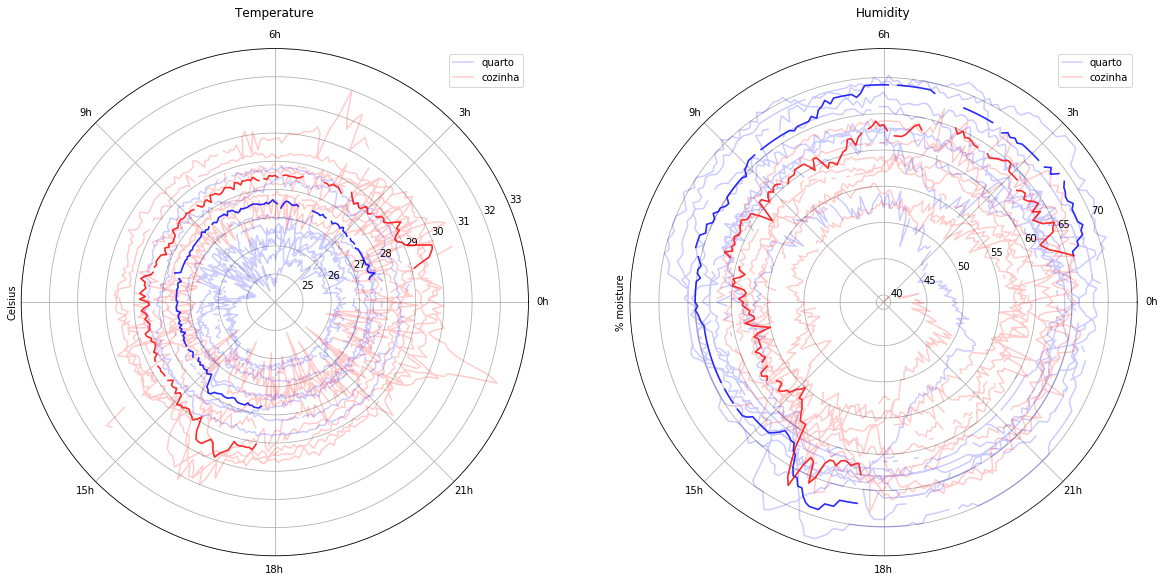

In [13]:
dfx['theta'] = dfx['date2']  * np.pi / 24. * 2
last = 200

fig = plt.figure(figsize=(20,30))

## Temperature
ax = fig.add_subplot(1,2,1,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Temperature')
plt.ylabel('Celsius')
ax.plot(dfx['theta'] , dfx['field1'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field3'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field1'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field3'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(limits[0])
ax.legend(('quarto','cozinha'))

## Humidity
ax = fig.add_subplot(1,2,2,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Humidity')
plt.ylabel('% moisture')
ax.plot(dfx['theta'] , dfx['field2'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field4'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field2'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field4'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(limits[1])
ax.legend(('quarto','cozinha'))

plt.savefig('plot.png',dpi=96, bbox_inches = 'tight')
plt.show()



In [14]:
dfx.describe()

,field1,field2,field3,field4,date2,theta
count,2679.000000,2679.000000,2545.000000,2545.000000,3230.000000,3230.000000
mean,27.023379,63.393679,28.413420,58.273081,12.015918,3.145760
std,0.985094,4.551122,0.973053,4.467507,6.877852,1.800617
min,24.433333,44.500000,25.150000,39.000000,0.000000,0.000000
25%,26.266667,62.000000,27.633333,56.000000,6.083333,1.592613
50%,27.000000,64.000000,28.466667,58.333333,12.166667,3.185226
75%,27.700000,66.000000,29.200000,61.333333,17.833333,4.668756
max,28.900000,73.000000,32.400000,72.000000,23.916667,6.261369
